CNN  EfficientNetB3

Dividir Físicamente el dataset en 3 subconjuntos

In [2]:
import tensorflow as tf
import matplotlib.pyplot as plt
import random
from tensorflow.keras import layers, Model
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import os 

In [1]:
import splitfolders 

input_folder = 'dataset'  

output_folder= 'dividido'

splitfolders.ratio(input_folder, output= output_folder, seed=1337, ratio = (0.8, 0.1, 0.1))

Copying files: 3881 files [00:40, 95.03 files/s] 


In [5]:
train_dir = "dividido/train/"
val_dir = "dividido/val/"
test_dir = "dividido/test/"

In [6]:
IMG_SIZE = (224, 224)

train_data = tf.keras.preprocessing.image_dataset_from_directory(directory=train_dir,
                                                                 image_size=IMG_SIZE,
                                                                 label_mode="binary",
                                                                 batch_size=32)

test_data = tf.keras.preprocessing.image_dataset_from_directory(directory=test_dir,
                                                                 image_size=IMG_SIZE,
                                                                 label_mode="binary",
                                                                 batch_size=32,
                                                                shuffle=False)

val_data = tf.keras.preprocessing.image_dataset_from_directory(directory=val_dir,
                                                                 image_size=IMG_SIZE,
                                                                 label_mode="binary",
                                                                 batch_size=32,
                                                                shuffle=False)

Found 3023 files belonging to 2 classes.
Found 379 files belonging to 2 classes.
Found 376 files belonging to 2 classes.


Visualizar una muestra de imagenes

In [7]:
# Visualizando imagenes
def visualize_random_images(dataset_type="train", label_type="Others"): 
    sample = 9
    plt.figure(figsize=(15, 8))
    type_dir = train_dir if dataset_type=="train" else test_dir
    base_dir = os.path.join(type_dir, label_type)
    images = random.sample(os.listdir(base_dir), 9)
    
    for i, image in enumerate(images):
        plt.subplot(3, 3, i+1)
        img = plt.imread(os.path.join(base_dir, image))
        plt.imshow(img)

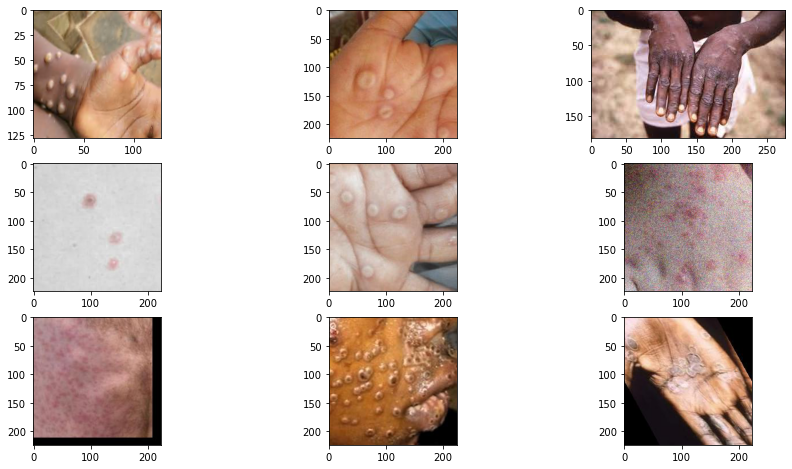

In [9]:
visualize_random_images("train", "M")

In [10]:
def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation metrics.
  Args:
    history: TensorFlow model History object (see: https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/History)
  """ 
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();

In [11]:
base_model = tf.keras.applications.EfficientNetB3(include_top=False)
base_model.trainable = True

for layer in base_model.layers[:-5]:
  layer.trainable = False

inputs = layers.Input(shape=(224, 224, 3), name="input_layer")
base_layer = base_model(inputs)
dropout_layer_1 = layers.Dropout(0.5)(base_layer)
flat_layer = layers.Flatten()(dropout_layer_1)
dense_1 = layers.Dense(256, activation="relu")(flat_layer)
dropout_layer_2 = layers.Dropout(0.5)(dense_1)
dense_2 = layers.Dense(128, activation="relu")(dropout_layer_2)
outputs = layers.Dense(1, activation="sigmoid")(dense_2)
model = Model(inputs, outputs)

In [13]:
model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.001),
                loss='binary_crossentropy',
                metrics=['accuracy'])

history = model.fit(train_data,
                       epochs=10,
                       validation_data=val_data)

C:\ProgramData\Anaconda3\envs\gpu_ok\lib\site-packages\keras\optimizer_v2\optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Epoch 1/10
95/95 [==============================] - 200s 2s/step - loss: 0.9628 - accuracy: 0.8270 - val_loss: 0.2258 - val_accuracy: 0.9362
Epoch 2/10
95/95 [==============================] - 145s 2s/step - loss: 0.4070 - accuracy: 0.9186 - val_loss: 0.2006 - val_accuracy: 0.9521
Epoch 3/10
95/95 [==============================] - 143s 2s/step - loss: 0.2367 - accuracy: 0.9471 - val_loss: 0.2604 - val_accuracy: 0.9495
Epoch 4/10
95/95 [==============================] - 145s 2s/step - loss: 0.1782 - accuracy: 0.9606 - val_loss: 0.1565 - val_accuracy: 0.9495
Epoch 5/10
95/95 [==============================] - 143s 2s/step - loss: 0.1518 - accuracy: 0.9649 - val_loss: 0.2696 - val_accuracy: 0.9521
Epoch 6/10
95/95 [==============================] - 142s 1s/step - loss: 0.1159 - accuracy: 0.9712 - val_loss: 0.1935 - val_accuracy: 0.9681
Epoch 7/10
95/95 [==============================] - 141s 1s/step - loss: 0.1234 - accuracy: 0.9725 - val_loss: 0.1021 - val_accuracy: 0.9814
Epoch 8/10
95

In [14]:
# Guardar el Modelo
model.save('Entrenado_monkeypox2.h5')


Mostrar curvas de entrenamiento / validacion

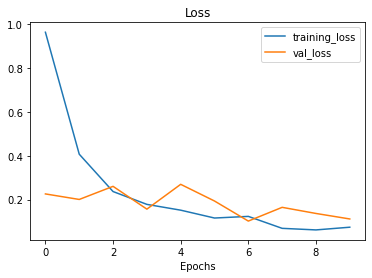

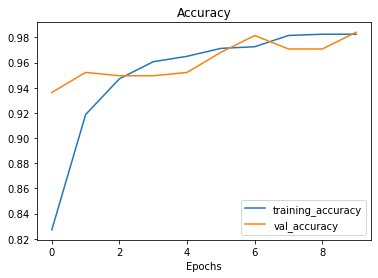

In [15]:
plot_loss_curves(history)

Evaluar el modelo, métricas

In [16]:
model.evaluate(test_data)

12/12 [==============================] - 27s 2s/step - loss: 0.2378 - accuracy: 0.9551


[0.2377968579530716, 0.9551451206207275]

In [17]:
y_pred = tf.math.round(model.predict(test_data))
y_true = []
for images, labels in test_data.unbatch():
  y_true.append(labels.numpy())

In [18]:
accuracy_score(y_true, y_pred)

0.9551451187335093

In [19]:
print(classification_report(y_true, y_pred, target_names=train_data.class_names))

              precision    recall  f1-score   support

           M       0.99      0.89      0.94       149
           N       0.93      1.00      0.96       230

    accuracy                           0.96       379
   macro avg       0.96      0.94      0.95       379
weighted avg       0.96      0.96      0.95       379



<AxesSubplot:>

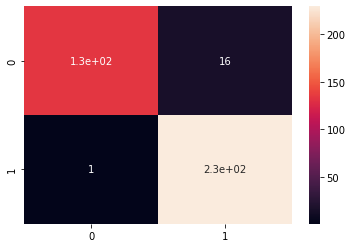

In [20]:
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm.astype("int"), annot=True)